In [ ]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [1]:
import os
from PIL import Image

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


label_dict = {"houses": 0, "lions": 1,"pandas": 2, "tigers": 3}
class_dict = {0: "houses", 1: "lions", 2: "pandas", 3: "tigers"}
N = 4

class MyDataset(Dataset):
    def __init__(self, _data_dir, _transform, _loader):
        self.labels = [_label for _label in os.listdir(_data_dir)]
        _file_path_label_list = [(os.path.join(_data_dir, _label, _img_fn), _label)
                                 for _label in os.listdir(_data_dir)
                                 for _img_fn in os.listdir(os.path.join(_data_dir, _label))
                                 if not os.path.isdir(os.path.join(_data_dir, _label, _img_fn))]

        self.data = [(_loader(_fp), label_dict[_label]) for _fp, _label in _file_path_label_list]
        self.transform = _transform

    def __getitem__(self, item):
        _img, _label = self.data[item]
        _img = self.transform(_img)
        return _img, _label

    def __len__(self):
        return len(self.data)


def load_data():
    print('data processing...')
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
    ])
    data_dir = "data/training_data/"
    train_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))
    test_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))

    train_size = int(len(train_dataset) * 0.8)
    validate_size = len(train_dataset) - train_size
    train, val = torch.utils.data.random_split(train_dataset, [train_size, validate_size])

    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader




In [4]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from classify.data_process import load_data
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)

class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.out = nn.Linear(10, N)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x


def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())

    return np.mean(val_loss)


@metric_time
def train():
    writer = SummaryWriter("log/")
    train_data_loader, val_data_loader, _ = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = 5
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, val_data_loader)
        writer.add_scalar("val_loss", val_loss, epoch)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    torch.save(best_model.state_dict(), "model/cnn.pkl")


@metric_time
def test():
    _, _, test_dataset = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"), False)
    total = 0
    current = 0
    model.eval()
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted = torch.max(outputs.data, 1)[1].data
        total += target.size(0)
        current += (predicted == target).sum()

    print('Accuracy:%d%%' % (100 * current / total))

In [5]:
train()

data processing...
train...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  3%|##7                                                                                | 1/30 [00:06<03:20,  6.90s/it]

Epoch 000 train_loss 1.20294 val_loss 1.24756


  7%|#####5                                                                             | 2/30 [00:13<03:07,  6.68s/it]

Epoch 001 train_loss 0.96097 val_loss 0.95915


 10%|########3                                                                          | 3/30 [00:20<02:59,  6.64s/it]

Epoch 002 train_loss 0.92877 val_loss 1.01880


 13%|###########                                                                        | 4/30 [00:26<02:51,  6.60s/it]

Epoch 003 train_loss 0.92400 val_loss 0.92400


 17%|#############8                                                                     | 5/30 [00:33<02:46,  6.66s/it]

Epoch 004 train_loss 0.90510 val_loss 0.91779


 20%|################6                                                                  | 6/30 [00:40<02:39,  6.67s/it]

Epoch 005 train_loss 0.88667 val_loss 0.97917


 23%|###################3                                                               | 7/30 [00:46<02:35,  6.76s/it]

Epoch 006 train_loss 0.86643 val_loss 0.90889


 27%|######################1                                                            | 8/30 [00:55<02:40,  7.29s/it]

Epoch 007 train_loss 0.87114 val_loss 0.92102


 30%|########################9                                                          | 9/30 [01:04<02:43,  7.76s/it]

Epoch 008 train_loss 0.88235 val_loss 0.89759


 33%|###########################3                                                      | 10/30 [01:12<02:40,  8.05s/it]

Epoch 009 train_loss 0.86883 val_loss 0.92759


 37%|##############################                                                    | 11/30 [01:22<02:42,  8.53s/it]

Epoch 010 train_loss 0.85990 val_loss 0.89993


 40%|################################8                                                 | 12/30 [01:31<02:33,  8.55s/it]

Epoch 011 train_loss 0.85780 val_loss 0.90176


 43%|###################################5                                              | 13/30 [01:39<02:26,  8.61s/it]

Epoch 012 train_loss 0.85241 val_loss 0.89922


 47%|######################################2                                           | 14/30 [01:48<02:18,  8.66s/it]

Epoch 013 train_loss 0.85972 val_loss 0.89613


 50%|#########################################                                         | 15/30 [01:57<02:10,  8.71s/it]

Epoch 014 train_loss 0.84944 val_loss 0.90425


 53%|###########################################7                                      | 16/30 [02:06<02:04,  8.87s/it]

Epoch 015 train_loss 0.84581 val_loss 0.91015


 57%|##############################################4                                   | 17/30 [02:16<01:57,  9.04s/it]

Epoch 016 train_loss 0.84326 val_loss 0.94012


 60%|#################################################1                                | 18/30 [02:24<01:47,  8.95s/it]

Epoch 017 train_loss 0.83836 val_loss 0.89398


 63%|###################################################9                              | 19/30 [02:33<01:38,  8.98s/it]

Epoch 018 train_loss 0.83651 val_loss 0.89214


 67%|######################################################6                           | 20/30 [02:42<01:30,  9.01s/it]

Epoch 019 train_loss 0.83903 val_loss 0.93095


 70%|#########################################################4                        | 21/30 [02:50<01:17,  8.58s/it]

Epoch 020 train_loss 0.84022 val_loss 0.88666


 73%|############################################################1                     | 22/30 [02:57<01:05,  8.14s/it]

Epoch 021 train_loss 0.83634 val_loss 0.89215


 77%|##############################################################8                   | 23/30 [03:05<00:55,  7.93s/it]

Epoch 022 train_loss 0.82680 val_loss 0.91950


 80%|#################################################################6                | 24/30 [03:13<00:48,  8.11s/it]

Epoch 023 train_loss 0.83456 val_loss 0.88402


 83%|####################################################################3             | 25/30 [03:22<00:41,  8.25s/it]

Epoch 024 train_loss 0.83567 val_loss 0.95371


 87%|#######################################################################           | 26/30 [03:30<00:33,  8.31s/it]

Epoch 025 train_loss 0.83971 val_loss 0.87963


 90%|#########################################################################8        | 27/30 [03:39<00:25,  8.43s/it]

Epoch 026 train_loss 0.83984 val_loss 0.88529


 93%|############################################################################5     | 28/30 [03:47<00:16,  8.39s/it]

Epoch 027 train_loss 0.83551 val_loss 0.89946


 97%|###############################################################################2  | 29/30 [03:56<00:08,  8.46s/it]

Epoch 028 train_loss 0.82951 val_loss 0.96253


100%|##################################################################################| 30/30 [04:04<00:00,  8.17s/it]


Epoch 029 train_loss 0.84878 val_loss 0.91241


2024-11-25 16:50:13.864 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 257.29798913002014 s


In [6]:
nn.Softmax

torch.nn.modules.activation.Softmax

In [7]:
test()

data processing...


2024-11-25 16:53:13.479 | DEBUG    | classify.decorator:wrapper:13 - test运行时间: 17.21324133872986 s


Accuracy:90%


In [30]:
pip install tensorboard loguru -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simpleNote: you may need to restart the kernel to use updated packages.



# 测试动物分类模型

In [31]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
import unittest
from PIL import Image

import torch
from matplotlib import pyplot as plt
from torchvision import transforms

from classify.data_process import class_dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

_img_path = "data/testing_data/pandas/panda (13).jpeg"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
# 模拟批样本
img_transform = transform(img).unsqueeze(0)

output = model(img_transform)
output

C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[-0.7439, -1.7432, -1.7436, -1.7435]], grad_fn=<LogSoftmaxBackward0>)

In [10]:
np.log(0.5)

-0.6931471805599453

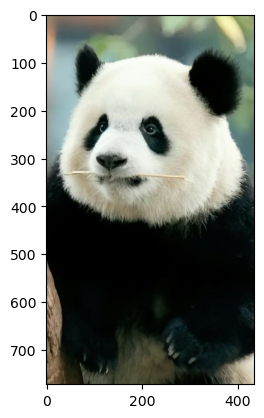

In [11]:
plt.imshow(img, cmap='gray')
plt.show()

In [14]:
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

houses


In [15]:
import torch
torch.__version__

'2.3.1+cu118'